# Meta learning momentum parameter
Can we learn/meta-learn the momentum parameter using the gradient of the loss during training?


Later on, can we learn/meta-learn all the hardcoded parameters? maybe even look ahead of the optimization using meta-learning of the past history of weights?

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
%run imports.py

Exception: File `'imports.py'` not found.

In [3]:
import util

In [4]:
ds = cifar10.CIFAR10()
# ds = mnist.MNIST()
model = cifar10.BigNetwork

Files already downloaded and verified
Files already downloaded and verified


In [5]:
net = model()

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
def zero_grad(net, set_to_none=True):
    for pi in net.parameters():
        pi.grad = None if set_to_none else torch.zeros_like(pi)

In [49]:
def train_adam(net, accu, lr=1e-2):
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    for epoch_idx in range(5):
        for x, y in tqdm(ds.dl_train):
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            print(loss.item())
            accu.append(loss_batch=loss.item())
            
def train_sgd(net, accu, lr=1e-2, momentum=0):
    mu = momentum
    v_prev = nn.utils.parameters_to_vector(net.parameters())
    m_prev = torch.zeros_like(v_prev)
    g_prev = torch.zeros_like(v_prev)
    for epoch_idx in range(5):
        for x, y in tqdm(ds.dl_train):
            m_now = g_prev + mu*m_prev.detach()
            v_now = v_prev.detach() - lr*m_now
            
            nn.utils.vector_to_parameters(v_prev.detach(), net.parameters())
            zero_grad(net)
            
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            loss.backward()
            g_now = torch.cat([pi.grad.detach().flatten() for pi in net.parameters()])
            
            dot = (m_prev*g_now).sum().item()
            step_size = (v_now-v_prev).norm()
            print(f'loss: {loss.item()}, mu: {mu}, dot: {dot}, step_size: {step_size}')
            accu.append(loss_batch=loss.item(), momentum=mu, dot=dot, step_size=step_size)
            
            v_prev = v_now
            m_prev = m_now
            g_prev = g_now
            
def train_meta(net, accu, lr=1e-2, momentum=0, lr_momentum=1e-2):
    mu_dofs = momentum
    
    def calc_mu(mu_dofs):
        return mu_dofs.sigmoid()
        # return mu.clamp(0, 1)
    
    mu_dofs = torch.tensor(mu_dofs).float().requires_grad_()
    
    opt = torch.optim.Adam([mu_dofs], lr=lr_momentum)
    
    v_prev = nn.utils.parameters_to_vector(net.parameters())
    m_prev = torch.zeros_like(v_prev)
    g_prev = torch.zeros_like(v_prev)
    for epoch_idx in range(10):
        for x, y in tqdm(ds.dl_train):
            m = calc_mu(mu_dofs)*m.detach() + g
            v = vp.detach() - lr*m
            
            nn.utils.vector_to_parameters(v, net.parameters())
            zero_grad(net)
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            
            opt.zero_grad()
            
            loss.backward()
            g = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()]).detach()
            
            if v.grad_fn is not None:
                v.backward(g)
                mg = mu_dofs.grad
                # print(mg.item())
                
                proj = (g*pm.detach()).sum()*(-lr)
                print((proj/(-lr)).item())
                opt.step()
            
            vp = v
                
            
            print('loss ', loss.item(), 'momentum ', calc_mu(momentum).item())
            print()
            accu.append(loss_batch=loss.item(), momentum=calc_mu(momentum).item())
            
accu = util.Accumulator()
torch.manual_seed(0)
# train_meta(model(), accu, lr=1e-2, momentum=5., lr_momentum=1e-2)
train_sgd(model(), accu, lr=1e-2, momentum=0.99)

  0%|          | 0/50 [00:00<?, ?it/s]

loss: 2.3062119483947754, mu: 0.99, dot: 0.0, step_size: 0.00041829043766483665
loss: 2.309144973754883, mu: 0.99, dot: 0.001254730625078082, step_size: 0.0008137577679008245
loss: 2.3083150386810303, mu: 0.99, dot: 0.0022102277725934982, step_size: 0.0011226844508200884
loss: 2.311354160308838, mu: 0.99, dot: 0.004879652056843042, step_size: 0.0015773281920701265
loss: 2.3122310638427734, mu: 0.99, dot: 0.0073742372915148735, step_size: 0.0020702313631772995


KeyboardInterrupt: 

In [16]:
def train_meta(net, accu, n_epochs=10, lr=1e-2, momentum=0, lr_momentum=1e-2, device='cpu'):
    net = net.to(device)
    
    def calc_mu(mu_dofs):
        return mu_dofs.sigmoid()
        # return mu.clamp(0, 1)
    mu_dofs = torch.tensor(momentum).float().to(device).requires_grad_()
    opt = torch.optim.Adam([mu_dofs], lr=lr_momentum)
    
    theta_tm1 = nn.utils.parameters_to_vector(net.parameters())
    b_tm1 = torch.zeros_like(theta_tm1)
    g_t = torch.zeros_like(theta_tm1)
    
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
        for x, y in tqdm(ds.dl_train, leave=False):
            x, y = x.to(device), y.to(device)
            mu = calc_mu(mu_dofs)
            mu.retain_grad()
            b_t = g_t + mu*b_tm1.detach()
            theta_t = theta_tm1.detach() - lr*b_t
            
            nn.utils.vector_to_parameters(theta_t, net.parameters())
            zero_grad(net)
            opt.zero_grad()
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            loss.backward()
            g_tp1 = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()]).detach()
            
            theta_t.backward(g_tp1)
            # mu_dofs.grad
                
            dot = (g_tp1*b_tm1).sum()
            mu_grad_manual = -lr*dot
            mu_grad = mu.grad
            step_size = (theta_t-theta_tm1).norm()
            
            data = dict(loss_batch=loss.item(), momentum=mu.item(), dot=dot.item(),
                        mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), step_size=step_size.item())
            accu.append(**data)
            
            # print(f'loss: {loss.item()}, mu: {mu}, dot: {dot}, step_size: {step_size}')
            # print(dict(loss_batch=loss.item(), momentum=mu.item(), dot=dot.item(),
                       # mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), step_size=step_size.item()))
            loop.set_postfix(data)
            
            opt.step()
            
            
            theta_tm1 = theta_t
            g_t = g_tp1
            b_tm1 = b_t
            
# accu = util.Accumulator()
# torch.manual_seed(0)
# train_meta(model(), accu, lr=1e-2, momentum=5., lr_momentum=0, device=device)

In [24]:
data = {}
torch.manual_seed(0)
data['lr_mu=0'] = accu = util.Accumulator()
train_meta(model(), accu, lr=1e-2, momentum=5., lr_momentum=0, device=device)

torch.manual_seed(0)
data['lr_mu=1e-2'] = accu = util.Accumulator()
train_meta(model(), accu, lr=1e-2, momentum=5., lr_momentum=1e-2, device=device)

torch.manual_seed(0)
data['lr_mu=1e-1'] = accu = util.Accumulator()
train_meta(model(), accu, lr=1e-2, momentum=5., lr_momentum=1e-1, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

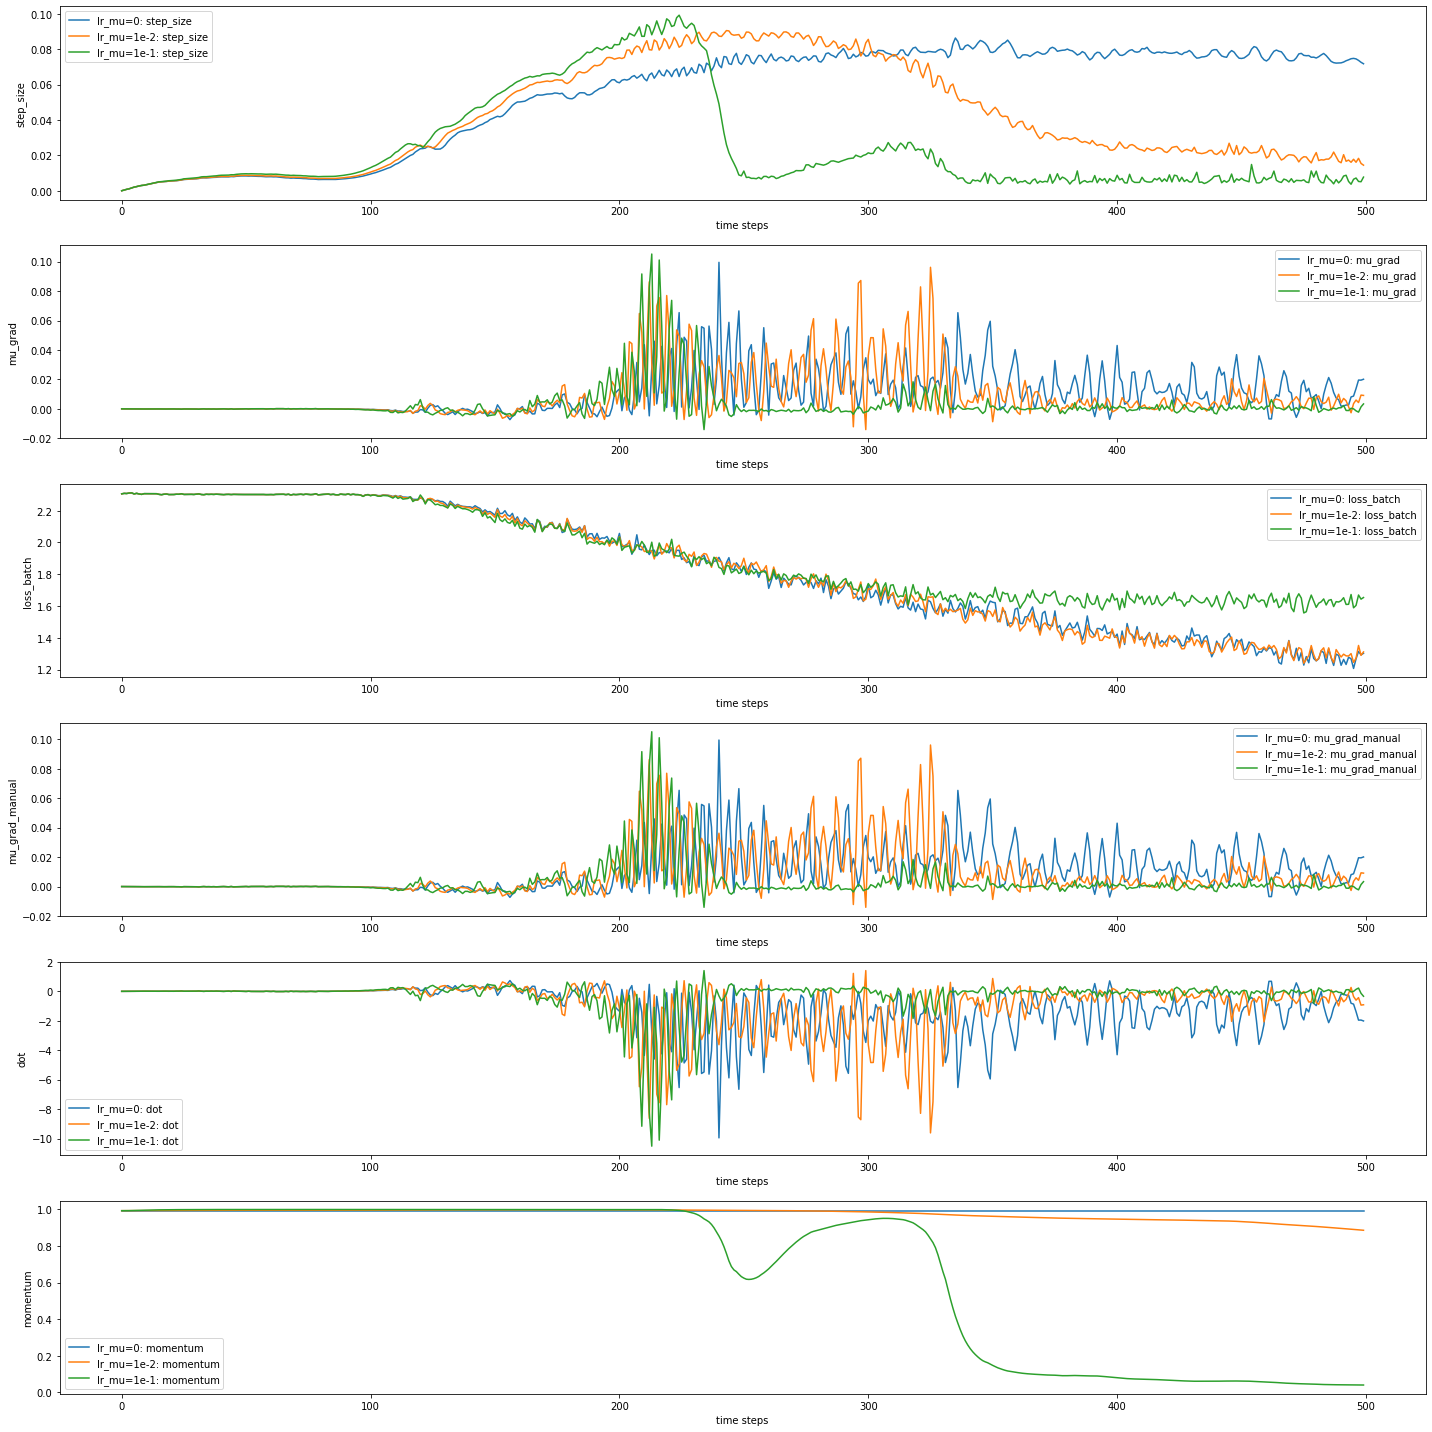

In [25]:
plt.figure(figsize=(20, 20))
util.plot_accumulators(data)

# Lesson:
The reason this doesn't work is not necessarily because of noise
it is because as you "turn a corner" in training, 
the gradient does not align with the momentum, and so the gradient of momentum goes all the way down
and so momentum decays.
Momentum decaying is not necessarily bad, it just means current gradient information is more important.
However, in our framework:
momentum decaying directly means that step size goes all the way down and learning stops.
that is why it goes into standstill.

# Try to augment step size in meta using step sizes from fixed momentum# Try to augment step size in meta using step sizes from fixed momentum# Try to augment step size in meta using step sizes from fixed momentum

In [30]:
ss_optimal = data['lr_mu=0']['step_size']

In [40]:
def train_meta(net, accu, n_epochs=10, lr=1e-2, momentum=0, lr_momentum=1e-2, device='cpu'):
    net = net.to(device)
    
    def calc_mu(mu_dofs):
        return mu_dofs.sigmoid()
        # return mu.clamp(0, 1)
    mu_dofs = torch.tensor(momentum).float().to(device).requires_grad_()
    opt = torch.optim.Adam([mu_dofs], lr=lr_momentum)
    
    theta_tm1 = nn.utils.parameters_to_vector(net.parameters())
    b_tm1 = torch.zeros_like(theta_tm1)
    g_t = torch.zeros_like(theta_tm1)
    
    i = 0
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
        for x, y in tqdm(ds.dl_train, leave=False):
            x, y = x.to(device), y.to(device)
            mu = calc_mu(mu_dofs)
            mu.retain_grad()
            b_t = g_t + mu*b_tm1.detach()
            theta_t = theta_tm1.detach() - lr*b_t
            
            nn.utils.vector_to_parameters(theta_t, net.parameters())
            zero_grad(net)
            opt.zero_grad()
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            loss.backward()
            g_tp1 = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()]).detach()
            
            theta_t.backward(g_tp1)
            # mu_dofs.grad
                
            dot = (g_tp1*b_tm1).sum()
            mu_grad_manual = -lr*dot
            mu_grad = mu.grad
            step_size = (theta_t-theta_tm1).norm()
            
            if step_size.item()>0:
                # print(theta_t, theta_tm1, step_size, ss_optimal[i])
                theta_t = theta_tm1 + (theta_t-theta_tm1)/step_size * ss_optimal[i]
            step_size = (theta_t-theta_tm1).norm()
            
            data = dict(loss_batch=loss.item(), momentum=mu.item(), dot=dot.item(),
                        mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), step_size=step_size.item())
            accu.append(**data)
            
            # print(f'loss: {loss.item()}, mu: {mu}, dot: {dot}, step_size: {step_size}')
            # print(dict(loss_batch=loss.item(), momentum=mu.item(), dot=dot.item(),
                       # mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), step_size=step_size.item()))
            loop.set_postfix(data)
            
            opt.step()
            
            
            theta_tm1 = theta_t
            g_t = g_tp1
            b_tm1 = b_t
            i+=1
            
torch.manual_seed(1)
accu = util.Accumulator()
train_meta(model(), accu, lr=1e-2, momentum=5., lr_momentum=1e-1, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

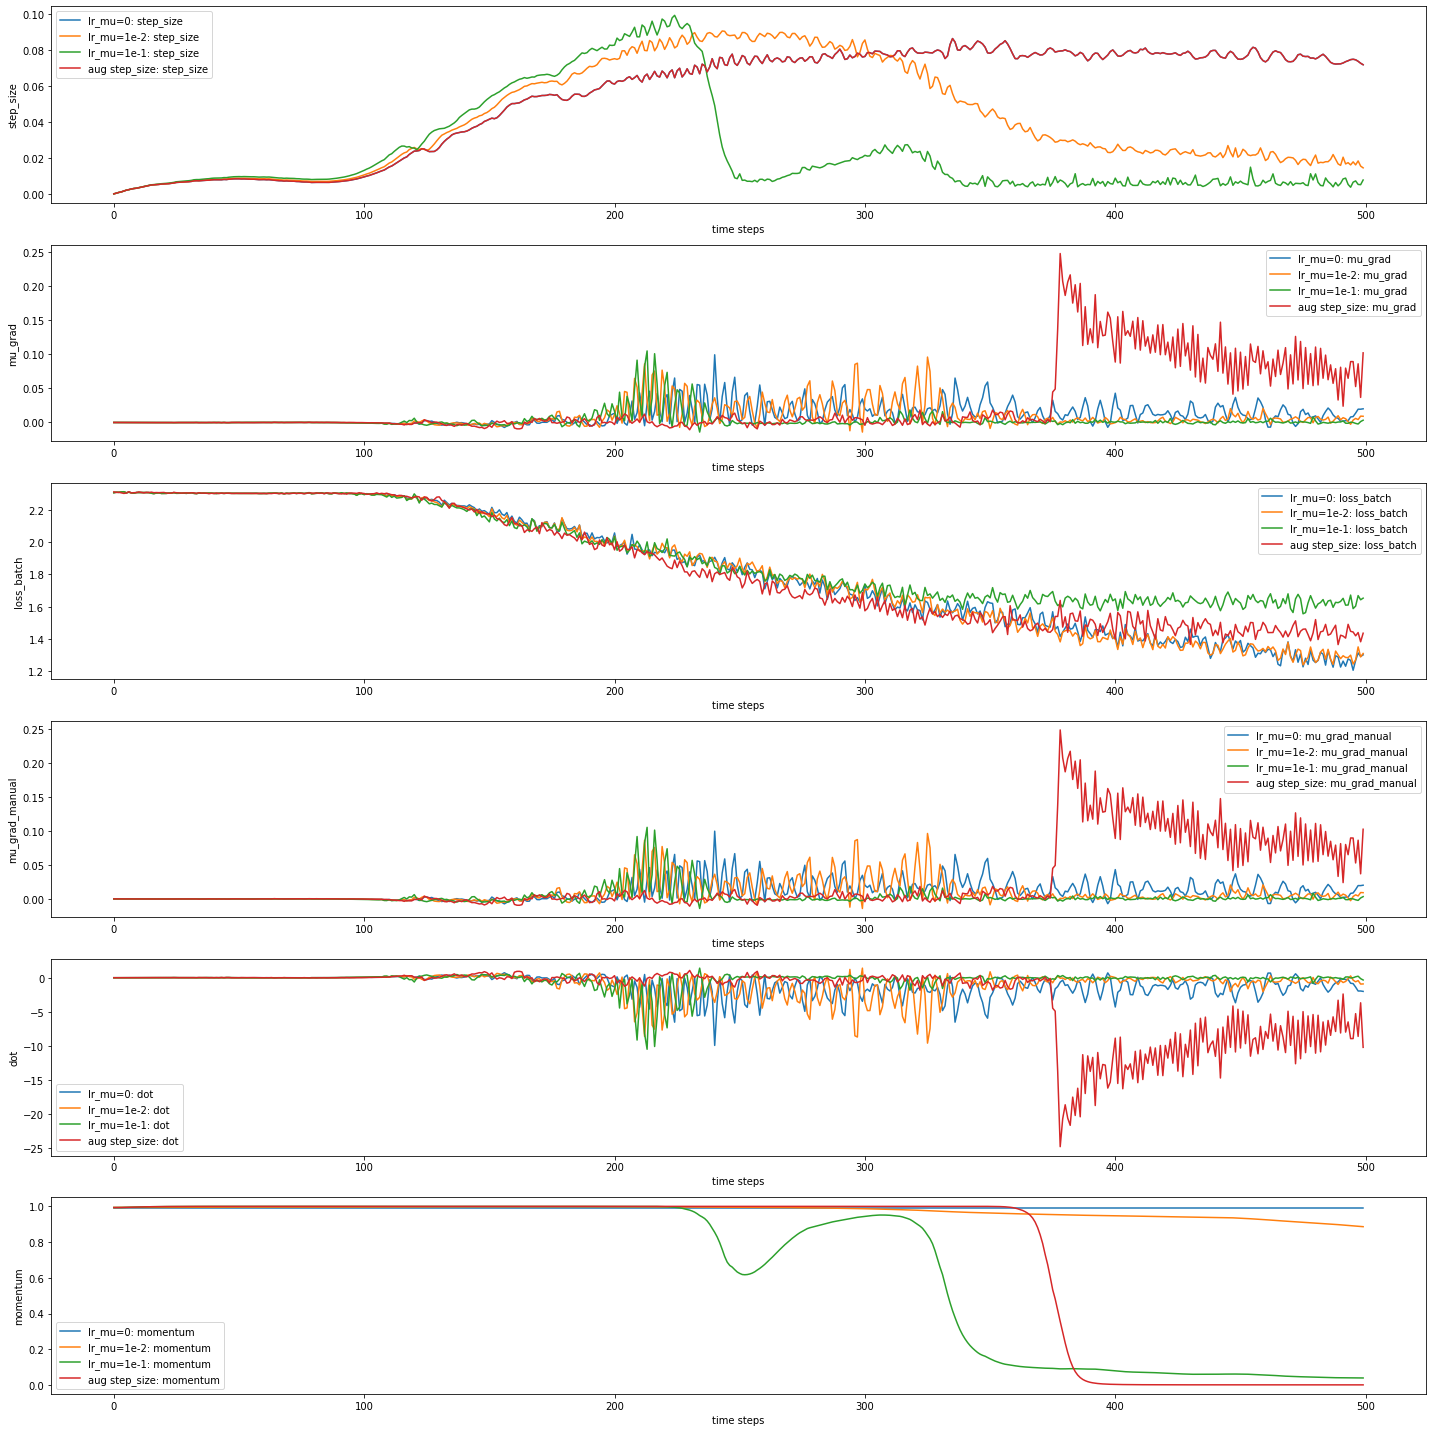

In [42]:
plt.figure(figsize=(20, 20))
util.plot_accumulators({**data, 'aug step_size': accu})


In [174]:
def train_meta(net, accu, n_epochs=10, lr=1e-2, momentum=0, lr_lr=1e-2, lr_momentum=1e-2, device='cpu'):
    net = net.to(device)
    
    def calc_mu(mu_dofs):
        return mu_dofs.sigmoid()
        # return mu.clamp(0, 1)
        
    def calc_lr(lr_dofs):
        return lr_dofs.exp()
    
    mu_dofs = torch.tensor(momentum).float().to(device).requires_grad_()
    opt = torch.optim.Adam([mu_dofs], lr=lr_momentum)
    
    lr_dofs = torch.tensor(np.log(lr)).float().to(device).requires_grad_()
    opt_lr = torch.optim.Adam([lr_dofs], lr=lr_lr)
    
    theta_tm1 = nn.utils.parameters_to_vector(net.parameters())
    b_tm1 = torch.zeros_like(theta_tm1)
    g_t = torch.zeros_like(theta_tm1)
    
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
        for batch_idx, (x, y) in enumerate(tqdm(ds.dl_train, leave=False)):
            x, y = x.to(device), y.to(device)
            mu = calc_mu(mu_dofs)
            mu.retain_grad()
            lr = calc_lr(lr_dofs)
            lr.retain_grad()
            
            b_tm1 = b_tm1.detach()
            theta_tm1 = theta_tm1.detach()
            
            b_t = g_t + mu*b_tm1
            theta_t = theta_tm1 - lr*b_t
            
            nn.utils.vector_to_parameters(theta_t, net.parameters())
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            loss.backward()
            g_tp1 = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()])
            zero_grad(net)
            
            theta_t.backward(g_tp1, retain_graph=True)
            # mu_dofs.grad
            
                
            dot = (g_tp1*b_tm1).sum()
            mu_grad_manual = -lr*dot
            mu_grad = mu.grad
            
            lr_grad_manual = -(g_tp1*(g_t+mu*b_tm1)).sum()
            lr_grad = lr.grad
            
            step_size = (theta_t-theta_tm1).norm()
            
            # if epoch_idx==0 and batch_idx==0:
                # b_tm1 = g_tp1.clone()
            
            # assert np.isclose(mu_grad_manual.item(), mu_grad.item())
            # assert np.isclose(lr_grad_manual.item(), lr_grad.item())
            
            data = dict(loss_batch=loss.item(), lr=lr.item(), momentum=mu.item(), dot=dot.item(),
                        mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), 
                        lr_grad=lr_grad.item(), lr_grad_manual=lr_grad_manual.item(), 
                        step_size=step_size.item())
            accu.append(**data)
            
            # print(f'loss: {loss.item()}, mu: {mu}, dot: {dot}, step_size: {step_size}')
            # print(dict(loss_batch=loss.item(), momentum=mu.item(), dot=dot.item(),
                       # mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), step_size=step_size.item()))
            loop.set_postfix(data)
            
            if batch_idx%3==0:
                opt.step()
                opt_lr.step()
                opt.zero_grad()
                opt_lr.zero_grad()
            
            
            theta_tm1 = theta_t
            g_t = g_tp1
            b_tm1 = b_t
            
torch.manual_seed(1)
accu = util.Accumulator()
train_meta(model(), accu, n_epochs=10, lr=1e-2, momentum=5., lr_lr=0, lr_momentum=1e-1, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

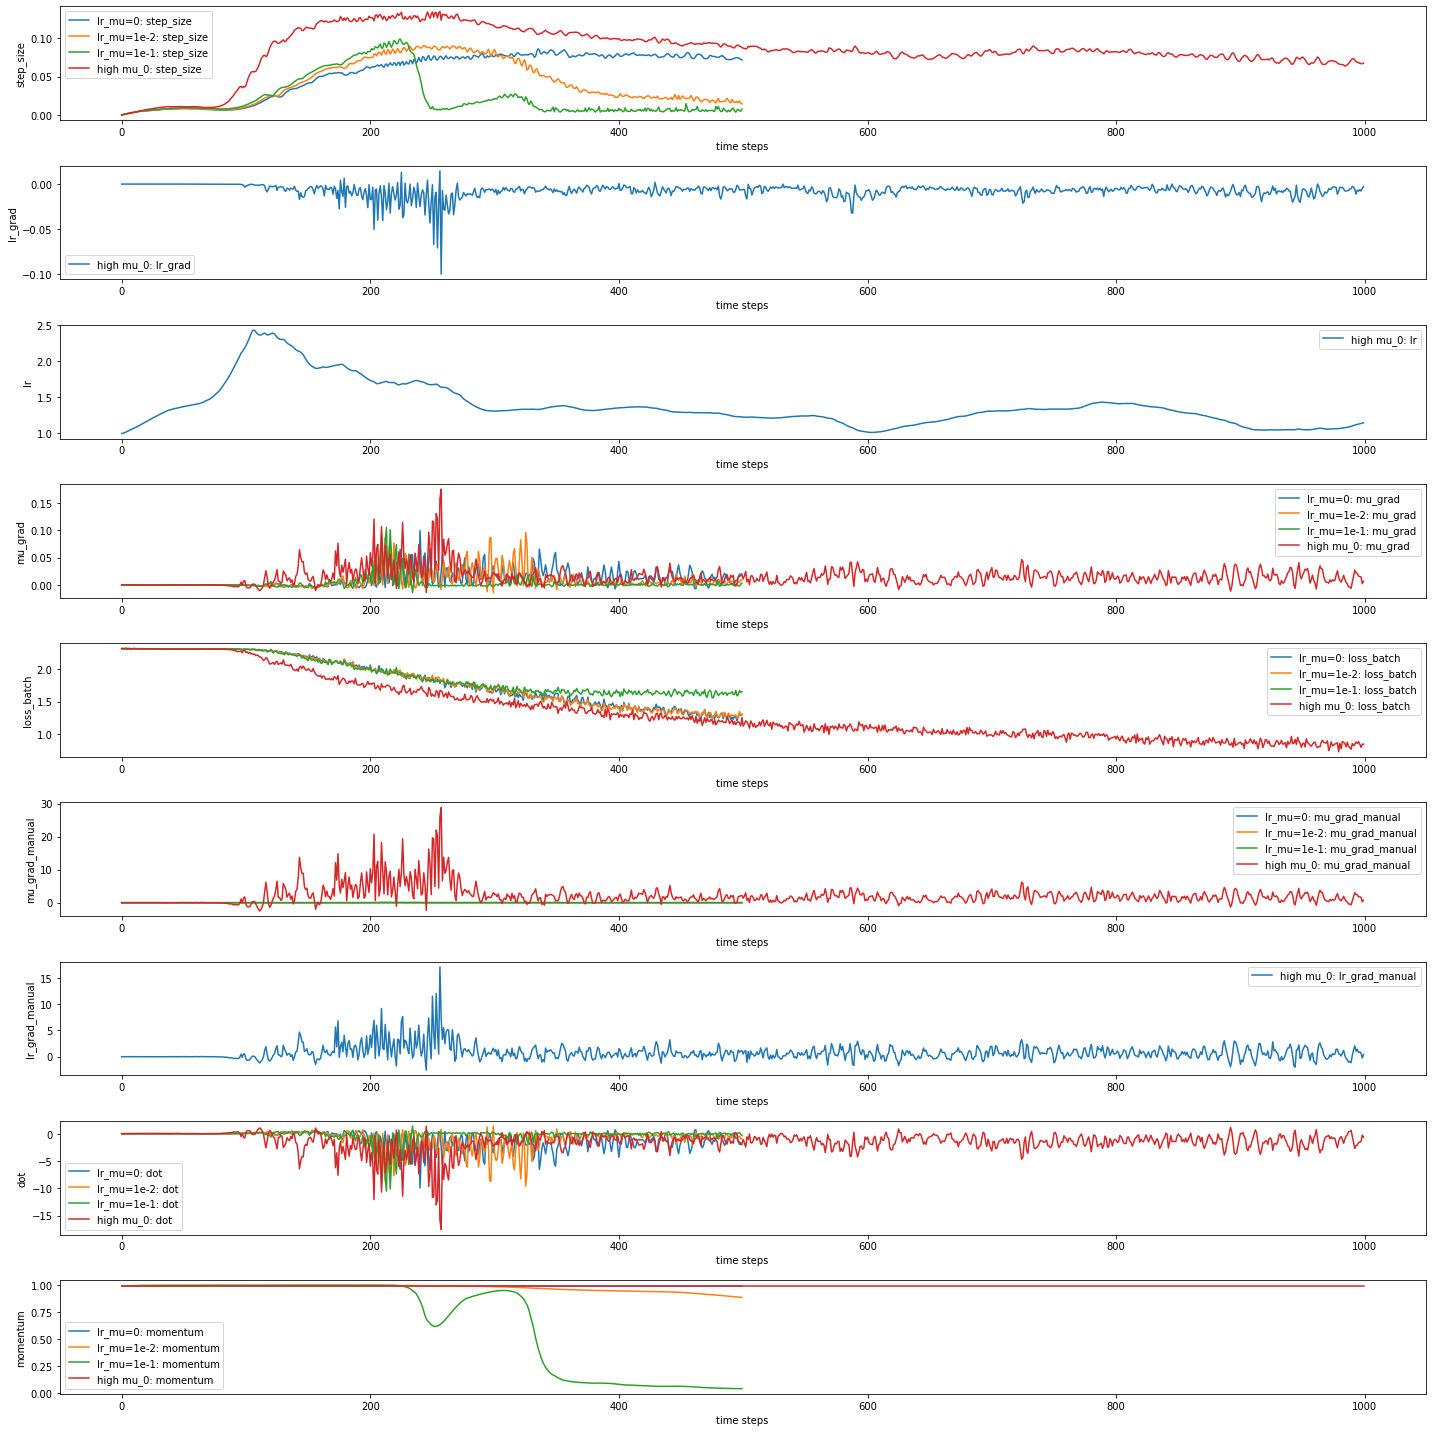

In [91]:
plt.figure(figsize=(20,20))
util.plot_accumulators({**data, 'high mu_0': accu})

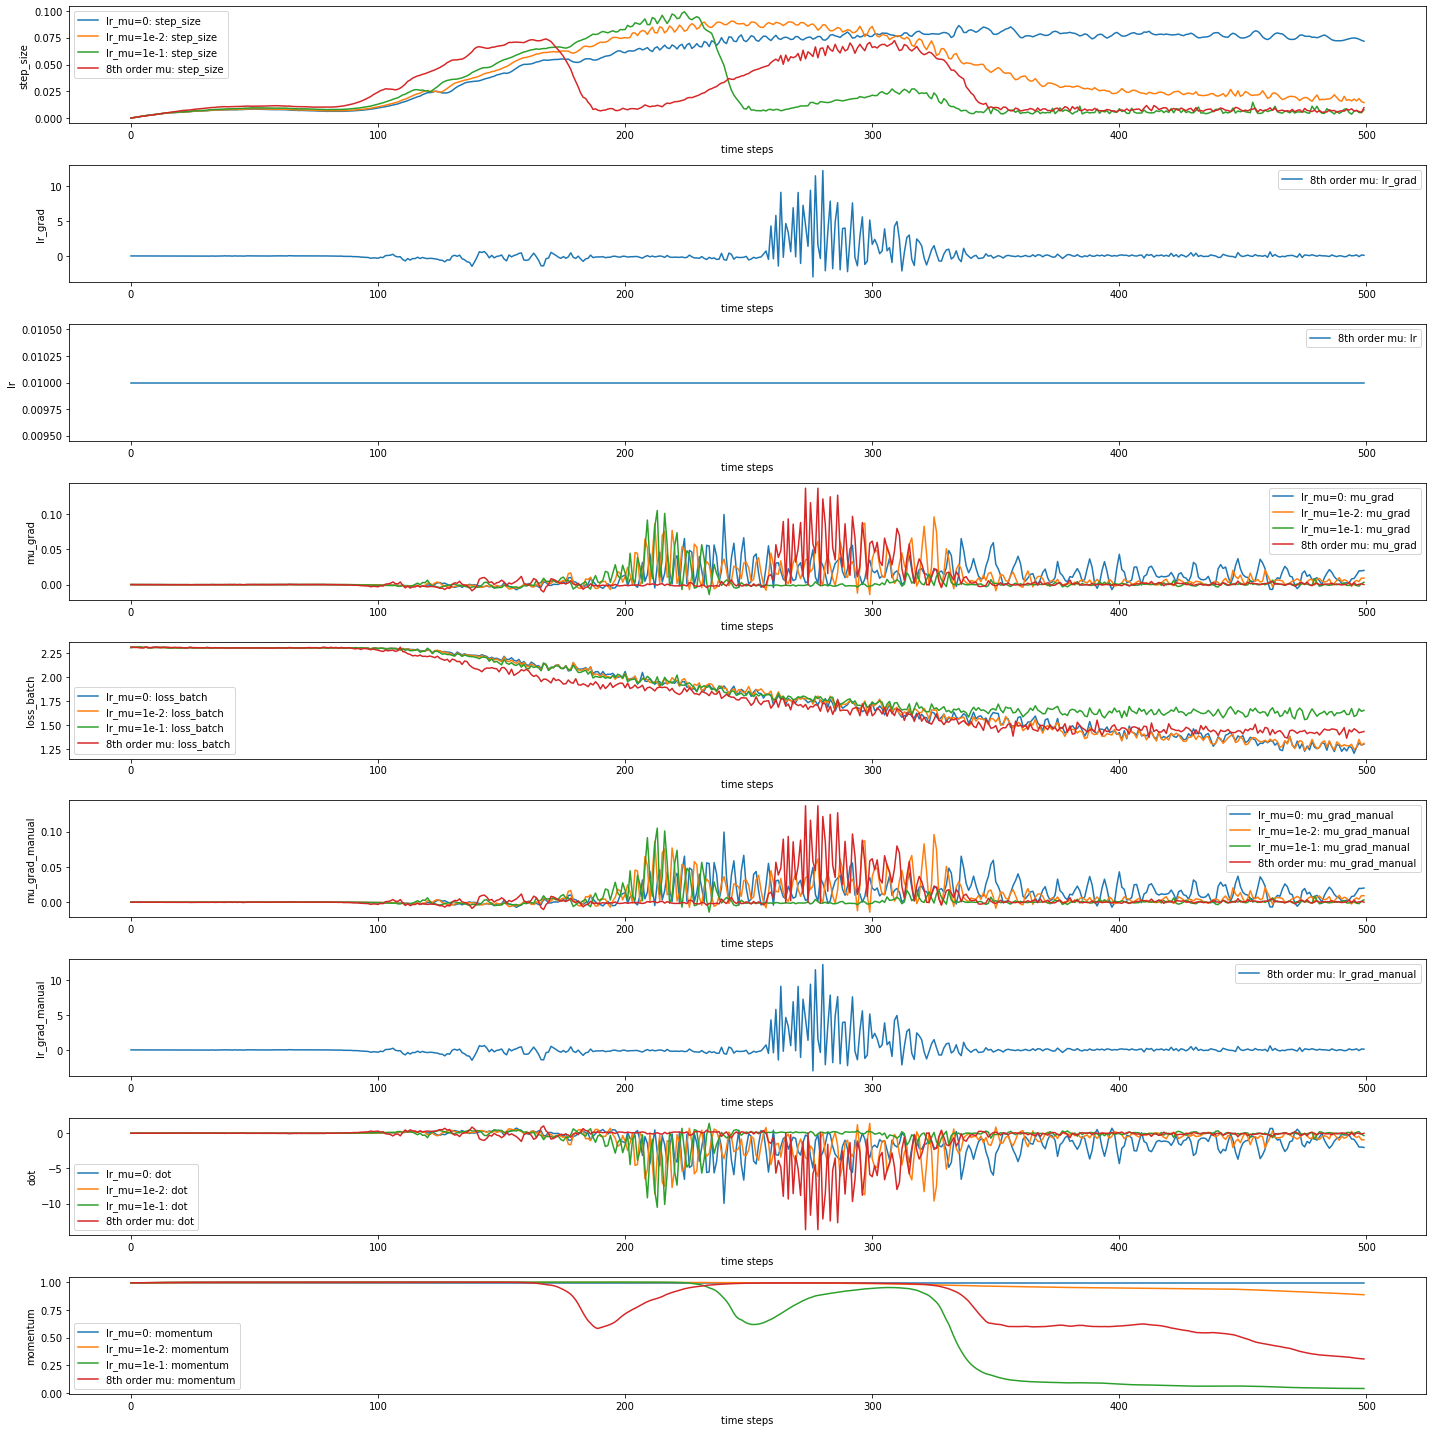

In [77]:
plt.figure(figsize=(20,20))
util.plot_accumulators({**data, '8th order mu': accu})

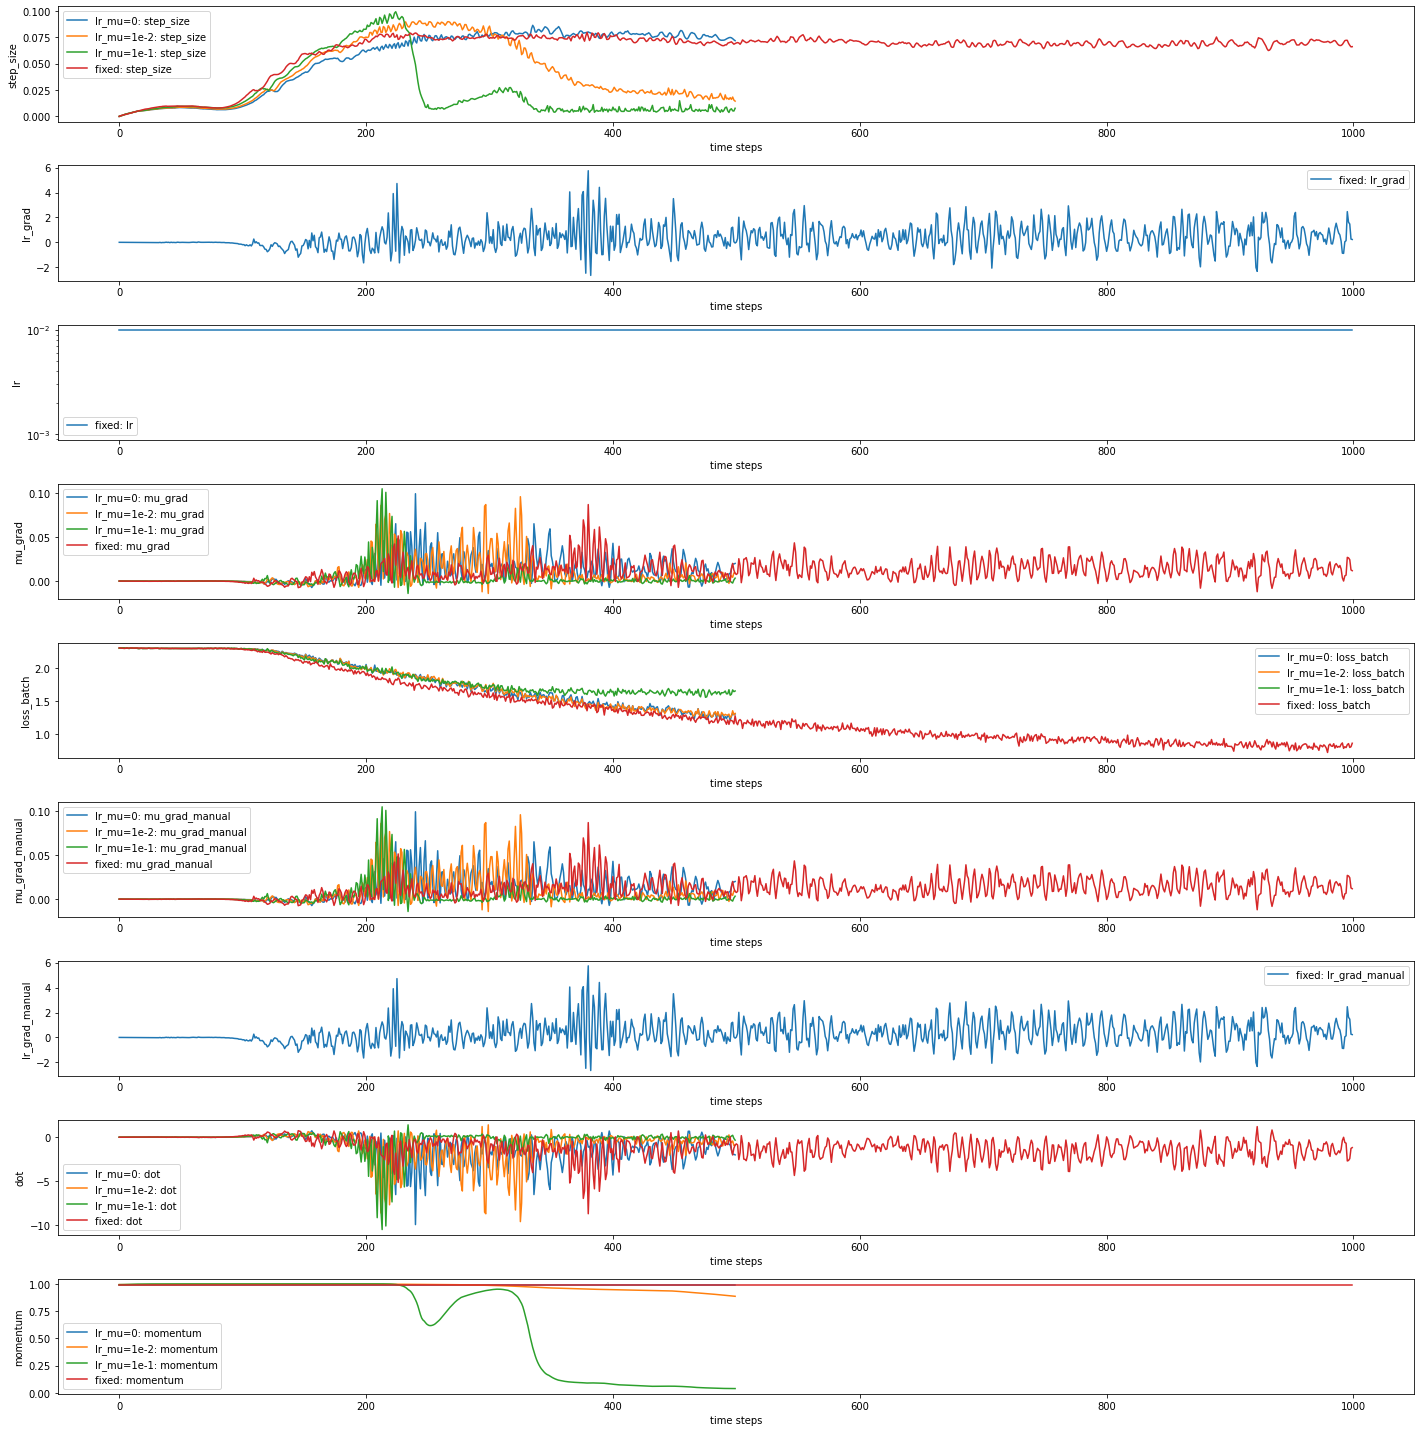

In [55]:
plt.figure(figsize=(20, 20))
util.plot_accumulators({**data, 'fixed': accu})
plt.subplot(9, 1, 3)
plt.yscale('log')

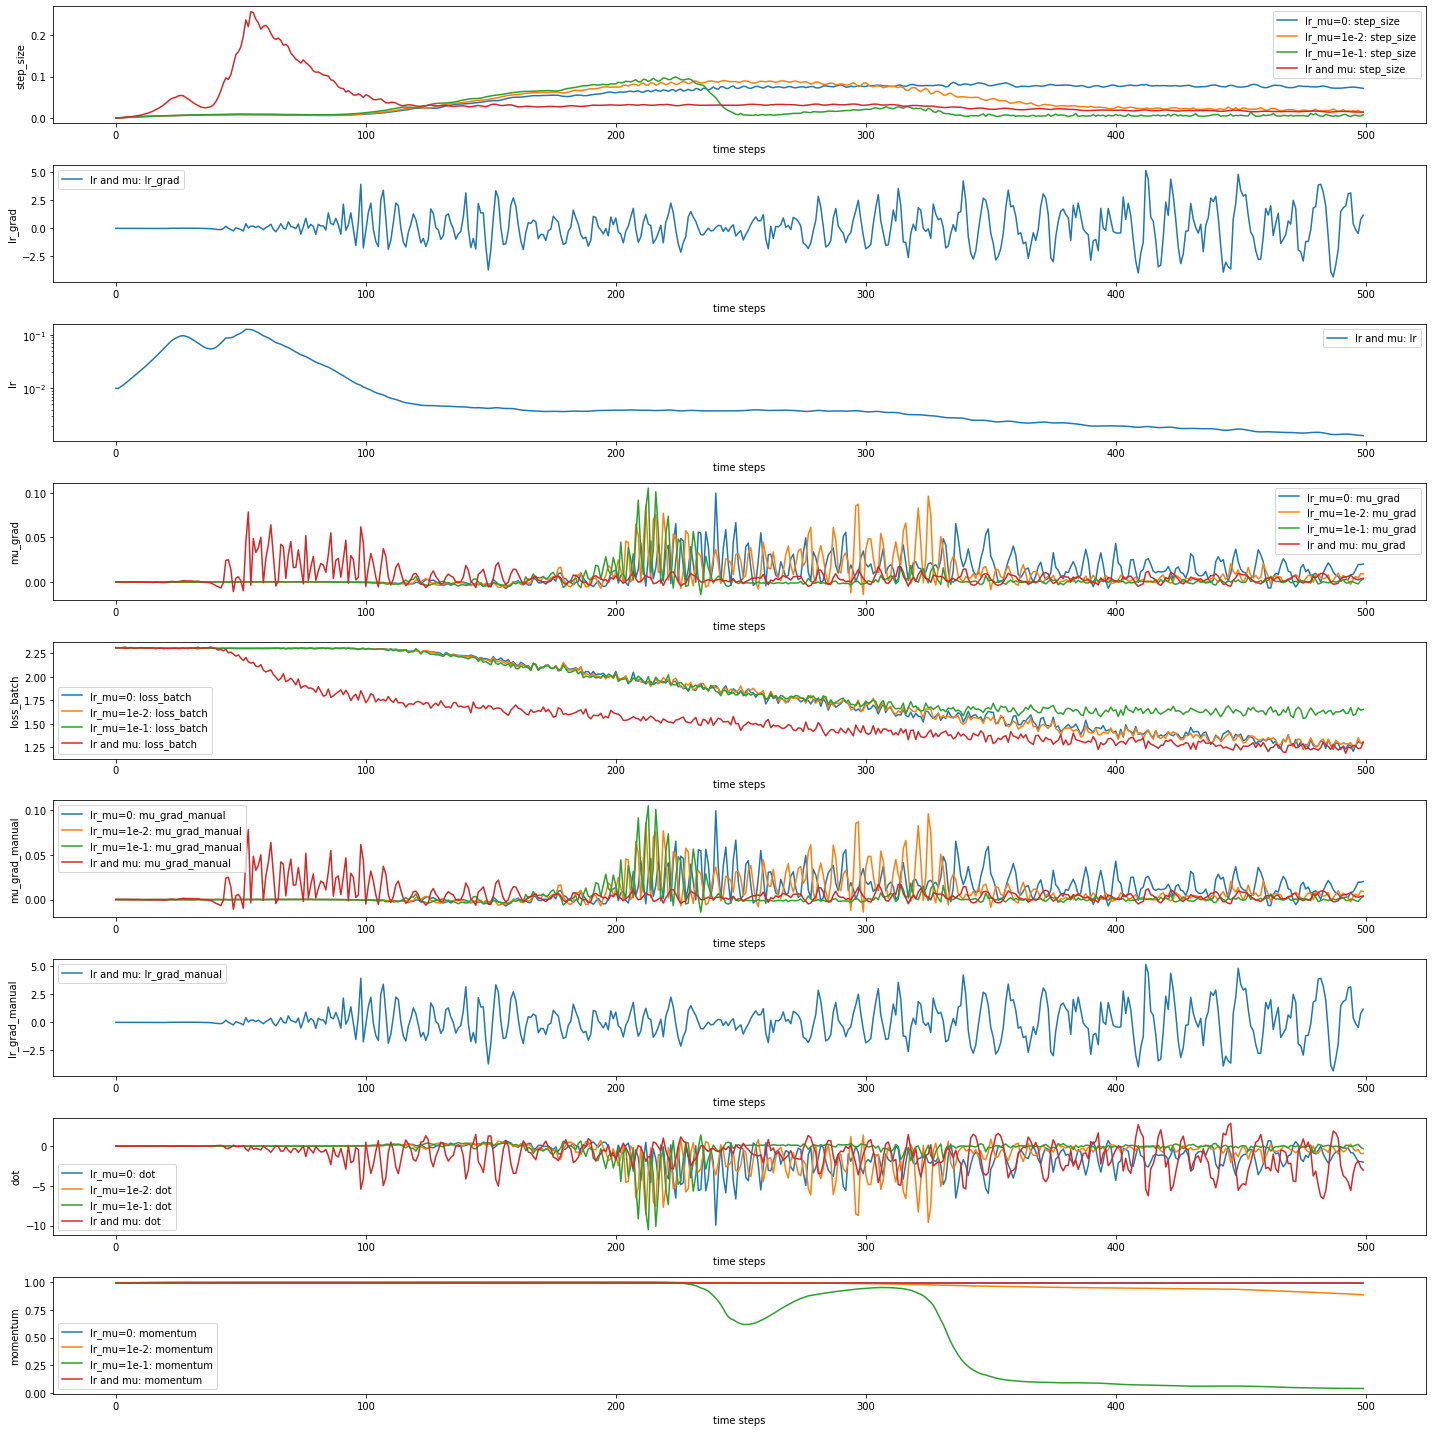

In [52]:
plt.figure(figsize=(20, 20))
util.plot_accumulators({**data, 'lr and mu': accu})
plt.subplot(9, 1, 3)
plt.yscale('log')

$g_t = \frac{dL}{d\theta_{t-1}} $

$g_{t+1} = \frac{dL}{d\theta_t} $

$b_{t} = g_t + \mu b_{t-1} = \mu^0 g_t + \mu^1 g_{t-1} + \mu^2 g_{t-2} + \mu^3 g_{t-3} + \dots + \mu^{t} g_0 = \sum_{i=0}^{t} \mu^{i} g_{t-i}$

$ \theta_{t-1} = \theta_{t-2} - \gamma b_{t-1} = \theta_{t-2} - \gamma g_{t-1} - \gamma \mu b_{t-2}$

$ \theta_t = \theta_{t-1} - \gamma b_{t} = \theta_{t-1} - \gamma g_t - \gamma \mu b_{t-1} = $
$ \theta_{t-2} - \gamma g_{t-1} - \gamma \mu b_{t-2} - \gamma g_t - \gamma \mu b_{t-1} $

$\frac{dL}{d\mu} = \frac{dL}{d\theta_{t}}\frac{d\theta_{t}}{d\mu} = g_{t+1}^T (-\gamma b_{t-1}) = -\gamma g_{t+1}^Tb_{t-1}$

$\frac{dL}{d\gamma} = \frac{dL}{d\theta_{t}}\frac{d\theta_{t}}{d\gamma} = g_{t+1}^T (-g_t-\mu b_{t-1}) = -g_{t+1}^T (g_t+\mu b_{t-1}) = -g_{t+1}^T b_t$

$\frac{db_t}{d\mu} = g_{t-1} + 2\mu g_{t-2} + 3\mu^2 g_{t-3} +\dots+ t\mu^{t-1} g_0$

$\frac{d\theta_{t-1}}{d\mu} = -\gamma b_{t-2}$

$\frac{dL}{d\mu} = \frac{dL}{d\theta_t}\frac{d\theta_t}{d\mu} = $
$g_{t+1}^T (\frac{d\theta_{t-1}}{d\mu} -\gamma \frac{db_t}{d\mu}) = $
$g_{t+1}^T (-\gamma b_{t-2} -\gamma \frac{db_t}{d\mu})$

In [137]:
def train_meta_adam(net, accu, n_epochs=10, lr=1e-2, beta1=0.9, beta2=0.999, lr_lr=1e-2, lr_beta1=1e-2, lr_beta2=1e-2, device='cpu'):
    net = net.to(device)
    
    def calc_lr_betas(lr_dofs, beta1_dofs, beta2_dofs):
        return lr_dofs.exp(), beta1_dofs.sigmoid(), beta2_dofs.sigmoid()
    
    beta1_dofs = torch.tensor(np.log(beta1/(1-beta1))).float().to(device).requires_grad_()
    beta2_dofs = torch.tensor(np.log(beta2/(1-beta2))).float().to(device).requires_grad_()
    lr_dofs = torch.tensor(np.log(lr)).float().to(device).requires_grad_()
    
    opt = torch.optim.Adam([{'params': lr_dofs, 'lr': lr_lr},
                            {'params': beta1_dofs, 'lr': lr_beta1},
                            {'params': beta2_dofs, 'lr': lr_beta2}],
                           lr=1e-3)
                           
    theta_tm1 = nn.utils.parameters_to_vector(net.parameters())
    m_tm1 = torch.zeros_like(theta_tm1)
    v_tm1 = torch.zeros_like(theta_tm1)
    
    g_t = torch.zeros_like(theta_tm1)
    
    time_step = 1
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
        for x, y in tqdm(ds.dl_train, leave=False):
            x, y = x.to(device), y.to(device)
            lr, beta1, beta2 = calc_lr_betas(lr_dofs, beta1_dofs, beta2_dofs)
            lr.retain_grad()
            beta1.retain_grad()
            beta2.retain_grad()
            
            m_t = beta1*m_tm1.detach() + (1-beta1)*g_t
            v_t = beta2*v_tm1.detach() + (1-beta2)*g_t.pow(2.)
            
            m_t_hat = m_t/(1-beta1.pow(time_step))
            v_t_hat = v_t/(1-beta2.pow(time_step))
            theta_t = theta_tm1.detach() - lr*m_t_hat/(v_t_hat.sqrt() + 1e-8)
            
            nn.utils.vector_to_parameters(theta_t, net.parameters())
            zero_grad(net)
            opt.zero_grad()
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            loss.backward()
            g_tp1 = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()]).detach()
            
            theta_t.backward(g_tp1)
            # mu_dofs.grad
                
            # dot = (g_tp1*b_tm1).sum()
            # mu_grad_manual = -lr*dot
            # mu_grad = mu.grad
            step_size = (theta_t-theta_tm1).norm()
            
            data = dict(loss_batch=loss.item(),
                        lr=lr.item(), beta1=1.-beta1.item(), beta2=1.-beta2.item(), 
                        lr_grad=lr.grad.item(), beta1_grad=beta1.grad.item(), beta2_grad=beta2.grad.item(), 
                        step_size=step_size.item())
            accu.append(**data)
            
            # print(f'loss: {loss.item()}, mu: {mu}, dot: {dot}, step_size: {step_size}')
            # print(dict(loss_batch=loss.item(), momentum=mu.item(), dot=dot.item(),
                       # mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), step_size=step_size.item()))
            loop.set_postfix(data)
            
            if time_step>1:
                opt.step()
            
            theta_tm1 = theta_t
            g_t = g_tp1
            m_tm1 = m_t
            v_tm1 = v_t
            
            time_step += 1
            
# torch.manual_seed(1)
# accu = util.Accumulator()
# train_meta_adam(model(), accu, lr=1e-2, beta1=0.9, beta2=0.999, lr_lr=0, lr_beta1=0, lr_beta2=0, device=device)

In [142]:
data = {}
torch.manual_seed(1)
data['adam_meta'] = accu = util.Accumulator()
train_meta_adam(model(), accu, lr=1e-2, beta1=0.9, beta2=0.999, lr_lr=1e-2, lr_beta1=1e-2, lr_beta2=1e-2, device=device)

torch.manual_seed(1)
data['adam'] = accu = util.Accumulator()
train_meta_adam(model(), accu, lr=1e-2, beta1=0.9, beta2=0.999, lr_lr=0, lr_beta1=0, lr_beta2=0, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

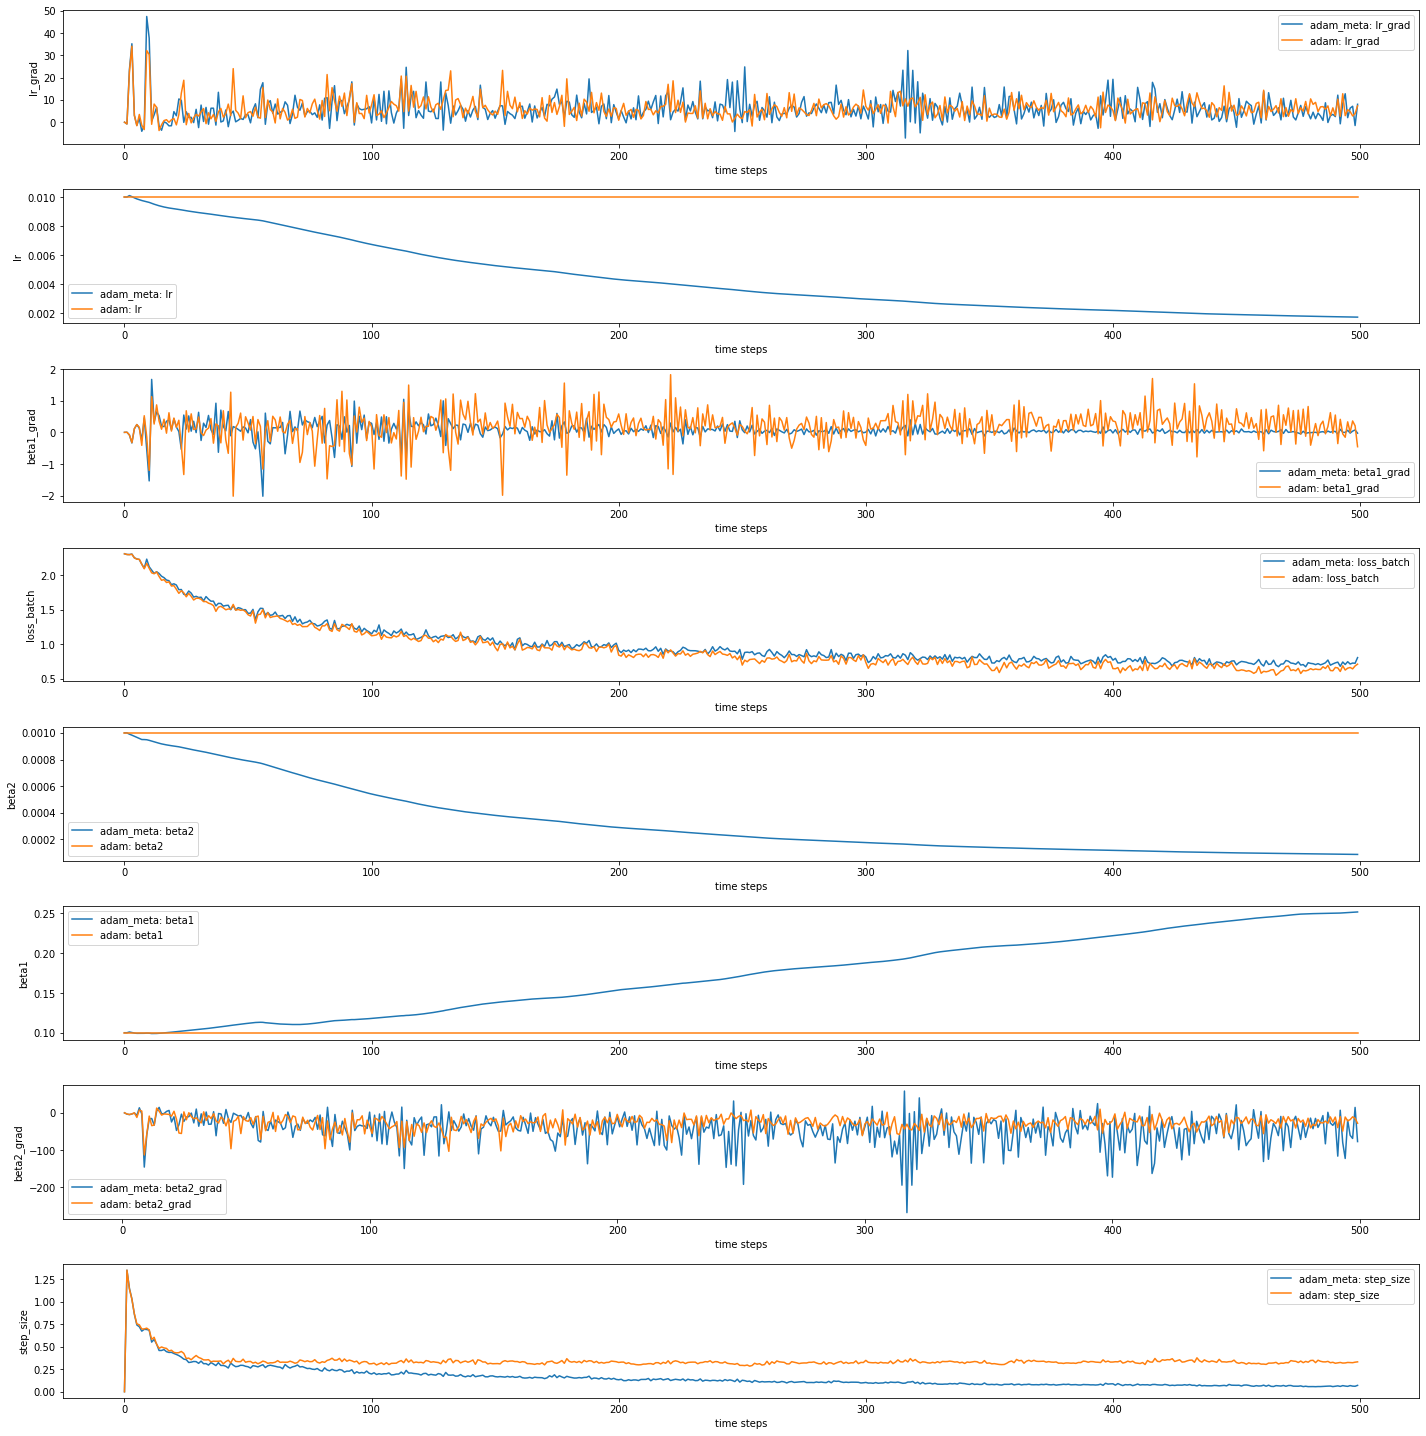

In [144]:
plt.figure(figsize=(20,20))
util.plot_accumulators(data)

In [9]:
def calc_loss_grad(theta, net, x=None, y=None, device='cpu'):
    if x is None or y is None:
        x, y = next(iter(ds.dl_train))
    x, y = x.to(device), y.to(device)
    net = net.to(device)
    theta = theta.to(device)
    
    nn.utils.vector_to_parameters(theta, net.parameters())
    yp = net(x)
    loss = ds.loss_fn(yp, y)

    zero_grad(net)
    loss.backward()
    g = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()])
    return loss, g
    

In [10]:
def inverse_sigmoid(x):
    if isinstance(x, torch.Tensor):
        return torch.log(x/(1-x))
    else:
        return np.log(x/(1-x))

# Identifying problem

In [ ]:
batches = [(x.to(device), y.to(device)) for x, y in tqdm(ds.dl_train)]

In [47]:
def graph_true_mu_grad(net, mu, theta, b, lr=1e-2, n_batches=10, eps=1e-3, device='cpu'):
    global batches
    if batches is None:
        batches = [[i.to(device) for i in next(iter(ds.dl_train))] for batch_idx in range(n_batches)]
    
    
    losses = []
    # for eps_i in [-eps, +eps]:
        # mu_i = (inverse_sigmoid(mu)+eps_i).sigmoid().detach()
    for eps_i in [-1, -.05, 0, +.05, +1]:
        mu_i = (mu.detach()+eps_i).clamp(0.1, .99)
        
        print(mu_i.item())
        losses.append([])
        theta_i = theta.detach().clone()
        b_i = b.detach().clone()
        for x, y in batches:
            loss, g = calc_loss_grad(theta_i, net, x=x, y=y, device=device)
            
            b_i = g + mu_i*b_i
            theta_i = theta_i - lr*b_i
            losses[-1].append(loss.item())
    losses = np.array(losses)
    plt.plot(losses[0], label=f'mu={0:0.03f}')
    plt.plot(losses[1], label=f'mu={(mu-0.05).clamp(0.1,.99).item():0.03f}')
    plt.plot(losses[2], label=f'mu={mu.item():0.03f}')
    plt.plot(losses[3], label=f'mu={(mu+0.05).clamp(0.1,.99).item():0.03f}')
    plt.plot(losses[4], label=f'mu={1:0.03f}')
    
    print(np.argsort(losses[:, -1]))
    plt.legend()
    plt.show()
    return losses


def graph_true_mu_grad(net, mu, theta, b, lr=1e-2, n_batches=10, eps=1e-3, device='cpu'):
    mus = np.array([(mu.detach()+eps_i).clamp(0.1, .99).item() for eps_i in [-1, -.05, 0, +.05, +1]])
    n_mus = len(mus)

    n_trajs = 30

    losses = xr.DataArray(np.zeros((n_mus, n_trajs, n_batches)), 
                          dims=('mu', 'traj', 'batch_idx'), coords={'mu': mus, 'batch_idx': np.arange(n_batches)})

    for traj_idx in tqdm(range(n_trajs)):
        ds_idxs = torch.randperm(len(batches))[:n_batches]
        for mu_idx, mu in enumerate(tqdm(mus)):
            mu_i = torch.tensor(mu).to(device)

            print(mu_i.item())
            theta_i = theta.detach().clone()
            b_i = b.detach().clone()
            for batch_idx, ds_idx in enumerate(ds_idxs):
                x, y = batches[ds_idx]
                loss, g = calc_loss_grad(theta_i, net, x=x, y=y, device=device)
                
                b_i = g + mu_i*b_i
                theta_i = theta_i - lr*b_i
                losses[mu_idx, traj_idx, batch_idx] = loss.item()


    return losses
            


# a = graph_true_mu_grad(model(), torch.tensor(0.999).float().cuda(), 
#                        nn.utils.parameters_to_vector(model().parameters()).detach().cuda(), 
#                        b=torch.randn(33098).cuda()/10., 
#                        lr=1e-2, n_batches=20, eps=5e-2, device='cuda')

    

In [48]:
def train_meta(net, accu, n_epochs=10, lr=1e-2, momentum=0, lr_lr=1e-2, lr_momentum=1e-2, device='cpu'):
    net = net.to(device)
    
    def calc_mu(mu_dofs):
        return mu_dofs.sigmoid()
        # return mu.clamp(0, 1)
        
    def calc_lr(lr_dofs):
        return lr_dofs.exp()
    
    mu_dofs = torch.tensor(momentum).float().to(device).requires_grad_()
    opt = torch.optim.Adam([mu_dofs], lr=lr_momentum)
    
    lr_dofs = torch.tensor(np.log(lr)).float().to(device).requires_grad_()
    opt_lr = torch.optim.Adam([lr_dofs], lr=lr_lr)
    
    theta_tm1 = nn.utils.parameters_to_vector(net.parameters())
    b_tm1 = torch.zeros_like(theta_tm1)
    g_t = torch.zeros_like(theta_tm1)

    mu_data = []
    
    loop = tqdm(range(n_epochs))
    for epoch_idx in loop:
        for batch_idx, (x, y) in enumerate(tqdm(ds.dl_train, leave=False)):
            x, y = x.to(device), y.to(device)
            mu = calc_mu(mu_dofs)
            mu.retain_grad()
            lr = calc_lr(lr_dofs)
            lr.retain_grad()
            
            b_tm1 = b_tm1.detach()
            theta_tm1 = theta_tm1.detach()
            
            b_t = g_t + mu*b_tm1
            theta_t = theta_tm1 - lr*b_t
            
            nn.utils.vector_to_parameters(theta_t, net.parameters())
            yp = net(x)
            loss = ds.loss_fn(yp, y)
            
            loss.backward()
            g_tp1 = torch.cat([pi.grad.flatten().detach() for pi in net.parameters()])
            zero_grad(net)
            
            theta_t.backward(g_tp1, retain_graph=True)
            # mu_dofs.grad
            
                
            dot = (g_tp1*b_tm1).sum()
            mu_grad_manual = -lr*dot
            mu_grad = mu.grad
            
            lr_grad_manual = -(g_tp1*(g_t+mu*b_tm1)).sum()
            lr_grad = lr.grad
            
            step_size = (theta_t-theta_tm1).norm()
            
            # if epoch_idx==0 and batch_idx==0:
                # b_tm1 = g_tp1.clone()
            
            # assert np.isclose(mu_grad_manual.item(), mu_grad.item())
            # assert np.isclose(lr_grad_manual.item(), lr_grad.item())
            
            data = dict(loss_batch=loss.item(), lr=lr.item(), momentum=mu.item(), dot=dot.item(),
                        mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), 
                        lr_grad=lr_grad.item(), lr_grad_manual=lr_grad_manual.item(), 
                        step_size=step_size.item())
            accu.append(**data)
            
            # print(f'loss: {loss.item()}, mu: {mu}, dot: {dot}, step_size: {step_size}')
            # print(dict(loss_batch=loss.item(), momentum=mu.item(), dot=dot.item(),
                       # mu_grad=mu_grad.item(), mu_grad_manual=mu_grad_manual.item(), step_size=step_size.item()))
            loop.set_postfix(data)
            
            opt.step()
            opt_lr.step()
            opt.zero_grad()
            opt_lr.zero_grad()
            
            
            theta_tm1 = theta_t
            g_t = g_tp1
            b_tm1 = b_t
            
            # if mu.item() < 0.9:
                # return net, mu.detach(), theta_t.detach(), b_t.detach()
        
        # print('current mu = ', mu_dofs.item(), mu.item())
            losses = graph_true_mu_grad(net, mu.detach(), theta_t.detach(), b_t.detach(),
                                        lr=lr, n_batches=10, eps=5e-1, device=device)
        mu_data.append((mu.item(), losses))
    return mu_data
            
torch.manual_seed(1)
accu = util.Accumulator()
# net, mu, theta, b = train_meta(model(), accu, n_epochs=10, lr=1e-2, momentum=5., lr_lr=0, lr_momentum=1e-1, device=device)
mu_data = train_meta(model(), accu, n_epochs=10, lr=1e-2, momentum=5., lr_lr=0, lr_momentum=1e-1, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

0.10000000149011612
0.9433071613311768
0.9900000095367432
0.9900000095367432
0.9900000095367432


  0%|          | 0/5 [00:00<?, ?it/s]

0.10000000149011612
0.9433071613311768
0.9900000095367432
0.9900000095367432
0.9900000095367432


  0%|          | 0/5 [00:00<?, ?it/s]

0.10000000149011612
0.9433071613311768
0.9900000095367432
0.9900000095367432
0.9900000095367432


  0%|          | 0/5 [00:00<?, ?it/s]

0.10000000149011612
0.9433071613311768
0.9900000095367432
0.9900000095367432
0.9900000095367432


  0%|          | 0/5 [00:00<?, ?it/s]

0.10000000149011612
0.9433071613311768
0.9900000095367432
0.9900000095367432
0.9900000095367432


  0%|          | 0/5 [00:00<?, ?it/s]

0.10000000149011612
0.9433071613311768
0.9900000095367432
0.9900000095367432
0.9900000095367432


  0%|          | 0/5 [00:00<?, ?it/s]

0.10000000149011612
0.9433071613311768
0.9900000095367432


KeyboardInterrupt: 

In [ ]:
import xarray as xr

In [ ]:
xr.DataArray

xarray.core.dataarray.DataArray

0.837941586971283
0.9379416108131409
0.0


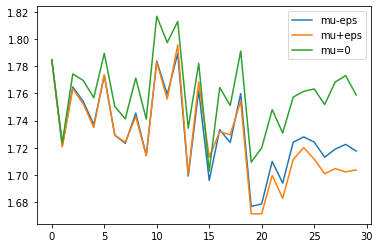

array([[1.78473413, 1.72108436, 1.7646575 , 1.75408816, 1.73697054,
        1.77314234, 1.72922969, 1.72327268, 1.74545646, 1.71449542,
        1.78373206, 1.7592988 , 1.78946483, 1.69918597, 1.76198781,
        1.69594824, 1.73328698, 1.72387064, 1.75982332, 1.67681468,
        1.67879117, 1.70993924, 1.69399142, 1.72405732, 1.7279799 ,
        1.72418642, 1.71306384, 1.71899927, 1.72248697, 1.71763825],
       [1.78473413, 1.72088516, 1.76350331, 1.75221252, 1.73497796,
        1.77368057, 1.72925186, 1.72412896, 1.74288821, 1.71415234,
        1.78300667, 1.75583422, 1.79568911, 1.70038557, 1.7684468 ,
        1.71299243, 1.73193288, 1.72951794, 1.75436997, 1.67135227,
        1.67149282, 1.6996758 , 1.68282688, 1.71134853, 1.72013509,
        1.71166074, 1.70090151, 1.70468593, 1.70227182, 1.70375538],
       [1.78473413, 1.72365379, 1.77428591, 1.76944244, 1.75677979,
        1.78939867, 1.75046468, 1.74125683, 1.77129304, 1.74105823,
        1.81672668, 1.79736781, 1.81289876, 1.

In [73]:

graph_true_mu_grad(net, mu.detach(), theta.detach(), b.detach(),
                   lr=1e-2, n_batches=30, eps=5e-1, device='cuda')

In [3]:
import torch

In [6]:
torch.randn(10000).cuda().norm()

tensor(99.3835, device='cuda:0')

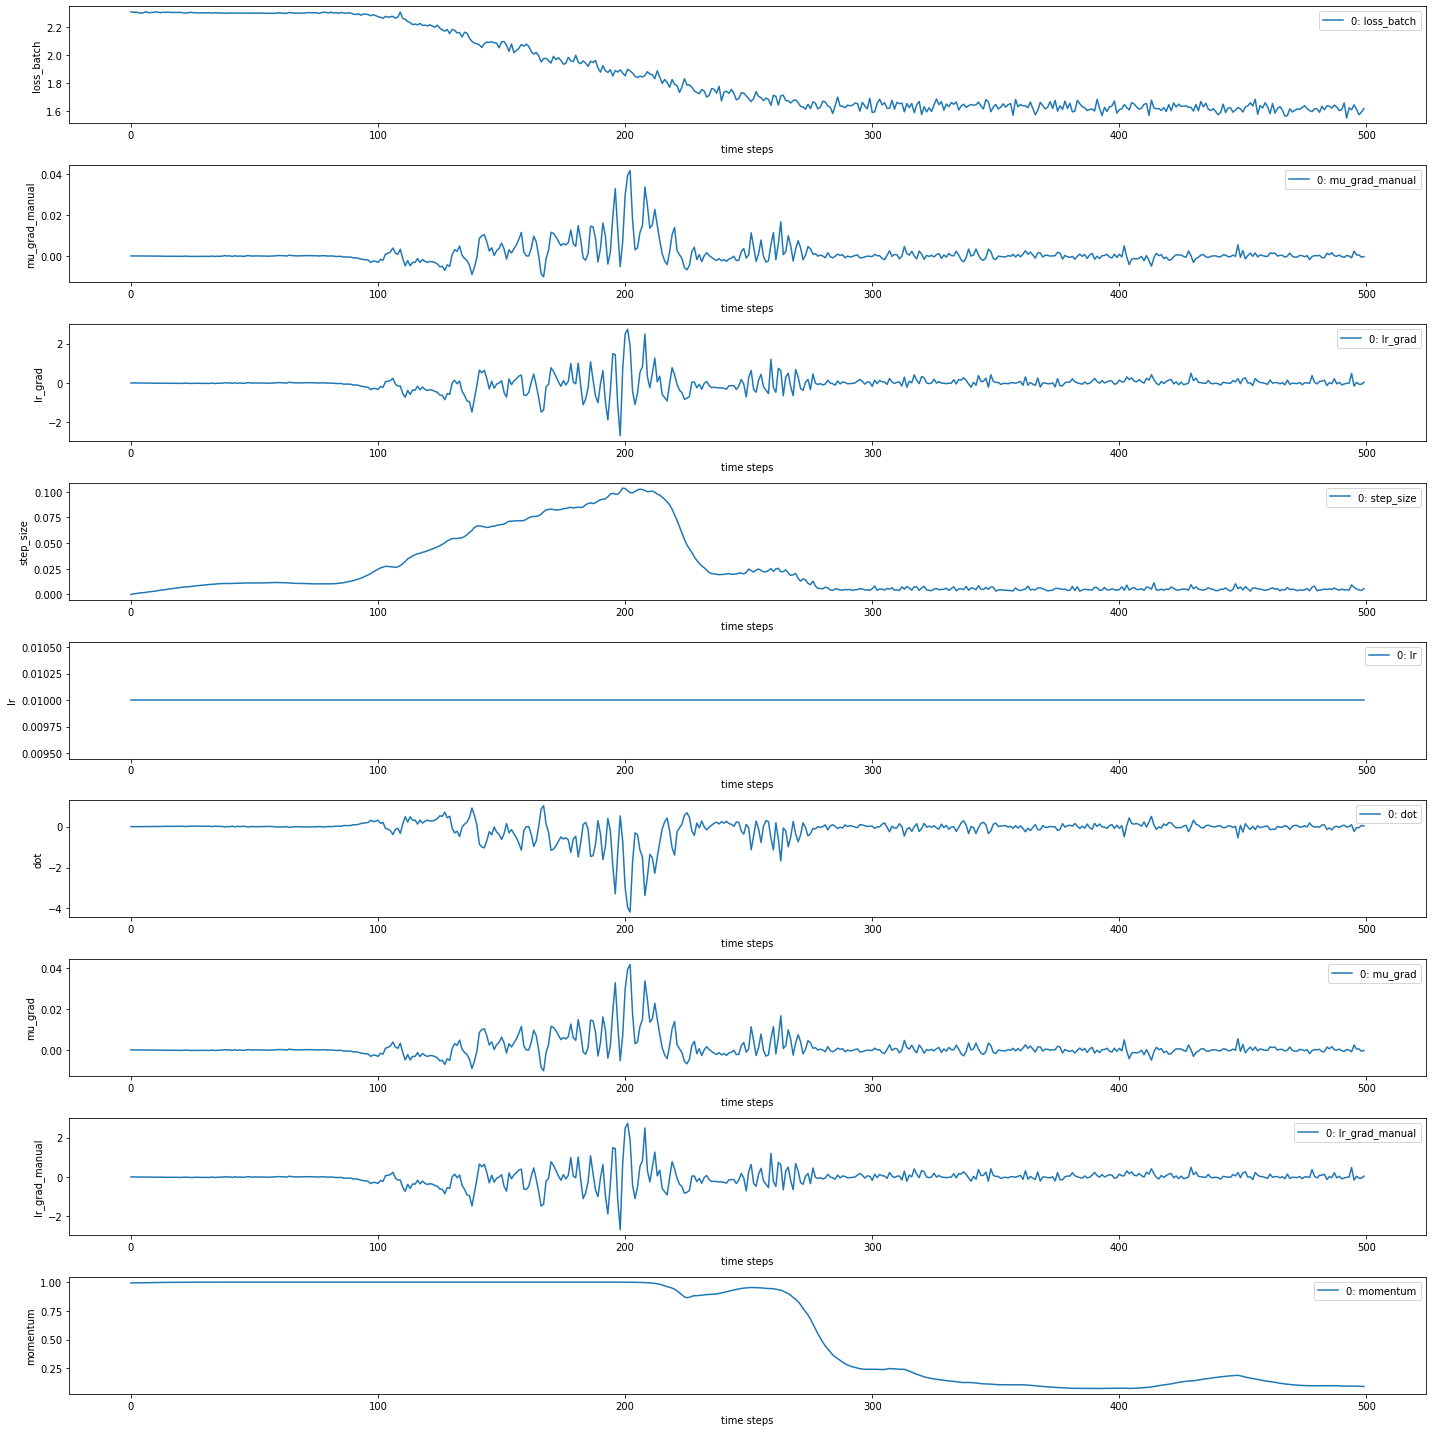

In [15]:
plt.figure(figsize=(20, 20))
util.plot_accumulators([accu])